# Exploratory Data Analysis

## Load Package

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from io import StringIO
from scipy import stats

## Load Dataset

In [26]:
df = pd.read_csv("../Dataset/EVSE-B-PowerCombined.csv")

print("Raw data preview:")
df.head()

Raw data preview:


,time,shunt_voltage,bus_voltage_V,current_mA,power_mW,State,Attack,Attack-Group,Label,interface
0,12/25/2023 22:35,978,5.165,1027,5300,idle,syn-flood,DoS,attack,ocpp
1,12/25/2023 22:35,872,5.161,1009,4980,idle,syn-flood,DoS,attack,ocpp
2,12/25/2023 22:35,1017,5.165,1029,5300,idle,syn-flood,DoS,attack,ocpp
3,12/25/2023 22:35,930,5.161,1005,5180,idle,syn-flood,DoS,attack,ocpp
4,12/25/2023 22:35,958,5.165,1034,5180,idle,syn-flood,DoS,attack,ocpp


In [27]:
print("\nData information:")
df.info()


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115298 entries, 0 to 115297
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           115298 non-null  object 
 1   shunt_voltage  115298 non-null  int64  
 2   bus_voltage_V  115298 non-null  float64
 3   current_mA     115298 non-null  int64  
 4   power_mW       115298 non-null  int64  
 5   State          115298 non-null  object 
 6   Attack         115298 non-null  object 
 7   Attack-Group   115298 non-null  object 
 8   Label          115298 non-null  object 
 9   interface      115298 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 8.8+ MB


## Initial Process

In [28]:
# Map time to 0 (night) or 1 (day)
def map_day_night(time_str):
    # Parse the time string into a datetime object
    time_obj = pd.to_datetime(time_str, format='%m/%d/%Y %H:%M')
    hour = time_obj.hour + time_obj.minute / 60
    # Daytime: 6:00 to 18:00
    if 6 <= hour < 18:
        return 1  # Daytime
    return 0  # Nighttime

# Apply the mapping
df['time'] = df['time'].apply(map_day_night)

# Check the first few rows to verify
print(df.head())

   time  shunt_voltage  bus_voltage_V  current_mA  power_mW State     Attack  \
0     0            978          5.165        1027      5300  idle  syn-flood   
1     0            872          5.161        1009      4980  idle  syn-flood   
2     0           1017          5.165        1029      5300  idle  syn-flood   
3     0            930          5.161        1005      5180  idle  syn-flood   
4     0            958          5.165        1034      5180  idle  syn-flood   

  Attack-Group   Label interface  
0          DoS  attack      ocpp  
1          DoS  attack      ocpp  
2          DoS  attack      ocpp  
3          DoS  attack      ocpp  
4          DoS  attack      ocpp  


In [29]:
# Encode diagnosis as 0 (benign) / 1 (malignant)
df['Label'] = df['Label'].map({'benign': 0, 'attack': 1})
print("\Label preview after encoding:")
print(df[['Label']].head())

\Label preview after encoding:
   Label
0      1
1      1
2      1
3      1
4      1


In [30]:
label_counts = df['Label'].value_counts()
print("\nLabel counts:")
print(f"Label 0 (benign): {label_counts.get(0, 0)}")
print(f"Label 1 (attack): {label_counts.get(1, 0)}")


Label counts:
Label 0 (benign): 14363
Label 1 (attack): 100935


In [31]:
# Separate the data into two DataFrames based on labels
df_label_0 = df[df['Label'] == 0]
df_label_1 = df[df['Label'] == 1]

# Randomly sample 14,363 rows from the Label 1 data to match Label 0 count
df_label_1_downsampled = df_label_1.sample(n=14363, random_state=42)

# Combine the downsampled Label 1 data with Label 0 data
df_balanced = pd.concat([df_label_0, df_label_1_downsampled])

# Shuffle the combined DataFrame to mix the labels
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new label counts
print("\nLabel counts after balancing:")
label_counts = df['Label'].value_counts()
print(f"Label 0 (benign): {label_counts.get(0, 0)}")
print(f"Label 1 (attack): {label_counts.get(1, 0)}")
print(df.head())


Label counts after balancing:
Label 0 (benign): 14363
Label 1 (attack): 14363
   time  shunt_voltage  bus_voltage_V  current_mA  power_mW State     Attack  \
0     1            469          5.201         466      2420  idle  tcp-flood   
1     1            466          5.201         465      2520  idle  tcp-flood   
2     1            432          5.205         459      2260  idle       none   
3     1            436          5.201         434      2300  idle       none   
4     1            510          5.197         509      2620  idle       none   

  Attack-Group  Label interface  
0          DoS      1      ocpp  
1          DoS      1      ocpp  
2         none      0      none  
3         none      0      none  
4         none      0      none  


In [32]:
# Separate feature matrix X and label y
X = df.drop(columns=['Label', 'State', 'Attack', 'Attack-Group', 'interface'])
y = df['Label']

In [33]:
# Save X and y
X.to_csv("../Dataset/X.csv", index=False)
y.to_csv("../Dataset/y.csv", index=False)

## Outlier

In [34]:
# Check for missing values and outliers
print("\nMissing value check:")
print(df.isnull().sum())


Missing value check:
time             0
shunt_voltage    0
bus_voltage_V    0
current_mA       0
power_mW         0
State            0
Attack           0
Attack-Group     0
Label            0
interface        0
dtype: int64


### Descriptive statistics

In [35]:
print("\nDescriptive statistics of data:")
print(X.describe())


Descriptive statistics of data:
               time  shunt_voltage  bus_voltage_V    current_mA      power_mW
count  28726.000000   28726.000000   28726.000000  28726.000000  28726.000000
mean       0.741280     586.497145       5.191134    585.969575   3041.103530
std        0.437939     168.871598       0.012464    168.543029    865.181843
min        0.000000     417.000000       5.149000    417.000000   2160.000000
25%        0.000000     466.000000       5.189000    466.000000   2420.000000
50%        1.000000     516.000000       5.197000    516.000000   2680.000000
75%        1.000000     645.000000       5.201000    643.000000   3340.000000
max        1.000000    1199.000000       5.209000   1220.000000   6100.000000


### Z-Score (standard score)

In [36]:
z_scores = np.abs(stats.zscore(X))
threshold = 3
outliers_z = (z_scores > threshold).sum(axis=0)

print("\nNumber of outliers based on Z-Score (per column):")
print(pd.Series(outliers_z, index=X.columns))


Number of outliers based on Z-Score (per column):
time               0
shunt_voltage     66
bus_voltage_V    101
current_mA        47
power_mW          64
dtype: int64


### IQR (Interquartile Range)

In [37]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((X < lower_bound) | (X > upper_bound)).sum()

print("\nNumber of outliers based on IQR (per column):")
print(outliers_iqr)


Number of outliers based on IQR (per column):
time                0
shunt_voltage    2867
bus_voltage_V    3539
current_mA       3006
power_mW         2818
dtype: int64


### Visualize outliers

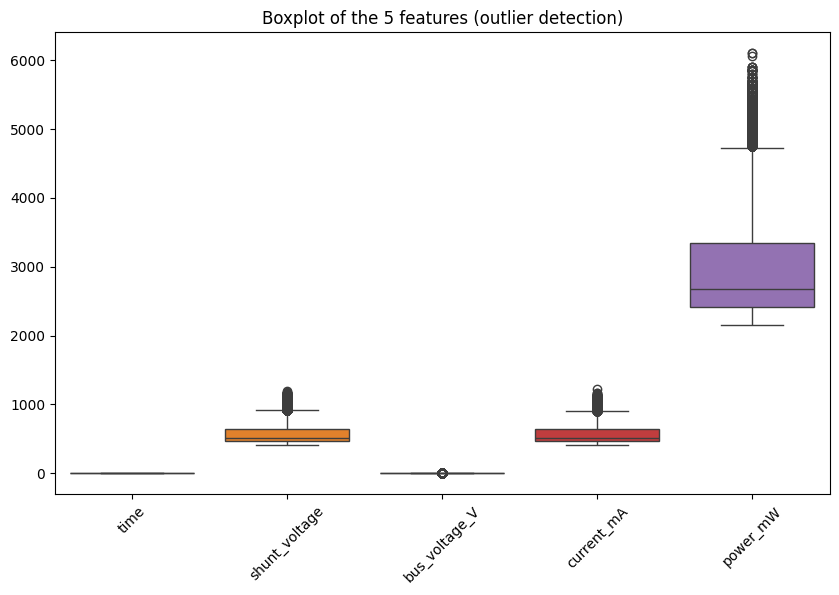

In [38]:
# Visualize outliers: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title("Boxplot of the 5 features (outlier detection)")
plt.xticks(rotation=45)
plt.show()

In [39]:
# If the number of outliers is small and likely noise, remove them
outlier_rows = (z_scores > threshold).any(axis=1)
print("\nNumber of outlier samples (Z-Score > 3):", outlier_rows.sum())

# If outliers are less than 5%, consider removing them
if outlier_rows.sum() < len(X) * 0.05:
    X_clean = X[~outlier_rows]
    y_clean = y[~outlier_rows]
    print("Data dimensions after removing outliers:", X_clean.shape)
else:
    X_clean = X
    y_clean = y
    print("Outliers may be related to malignant tumors, retaining all data, dimensions:", X_clean.shape)


Number of outlier samples (Z-Score > 3): 226
Data dimensions after removing outliers: (28500, 5)


In [40]:
y_clean.to_csv("../Dataset/y_clean.csv", index=False)

## Standardize all features

In [41]:
# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
print("\nPreview of standardized features:")
print(X_scaled.head())


Preview of standardized features:
       time  shunt_voltage  bus_voltage_V  current_mA  power_mW
0  0.583077      -0.692395       0.791456   -0.708318 -0.715008
1  0.583077      -0.710632       0.791456   -0.714400 -0.596377
2  0.583077      -0.917319       1.121534   -0.750892 -0.904818
3  0.583077      -0.893003       0.791456   -0.902942 -0.857365
4  0.583077      -0.443156       0.461379   -0.446792 -0.477746


In [42]:
# Check data dimensions
print("\nData dimensions:", X_scaled.shape)


Data dimensions: (28500, 5)


In [43]:
# Save X scale data
X_scaled.to_csv("../Dataset/X_scaled.csv", index=False)

## Visualizations

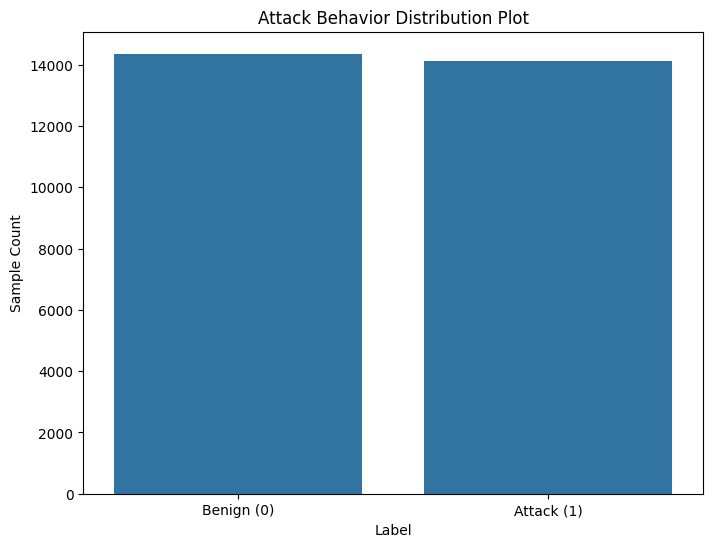

In [44]:
# Diagnosis distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(x=y_clean)
plt.title("Attack Behavior Distribution Plot")
plt.xlabel("Label")
plt.ylabel("Sample Count")
plt.xticks([0, 1], ['Benign (0)', 'Attack (1)'])
plt.show()

<Figure size 1400x800 with 0 Axes>

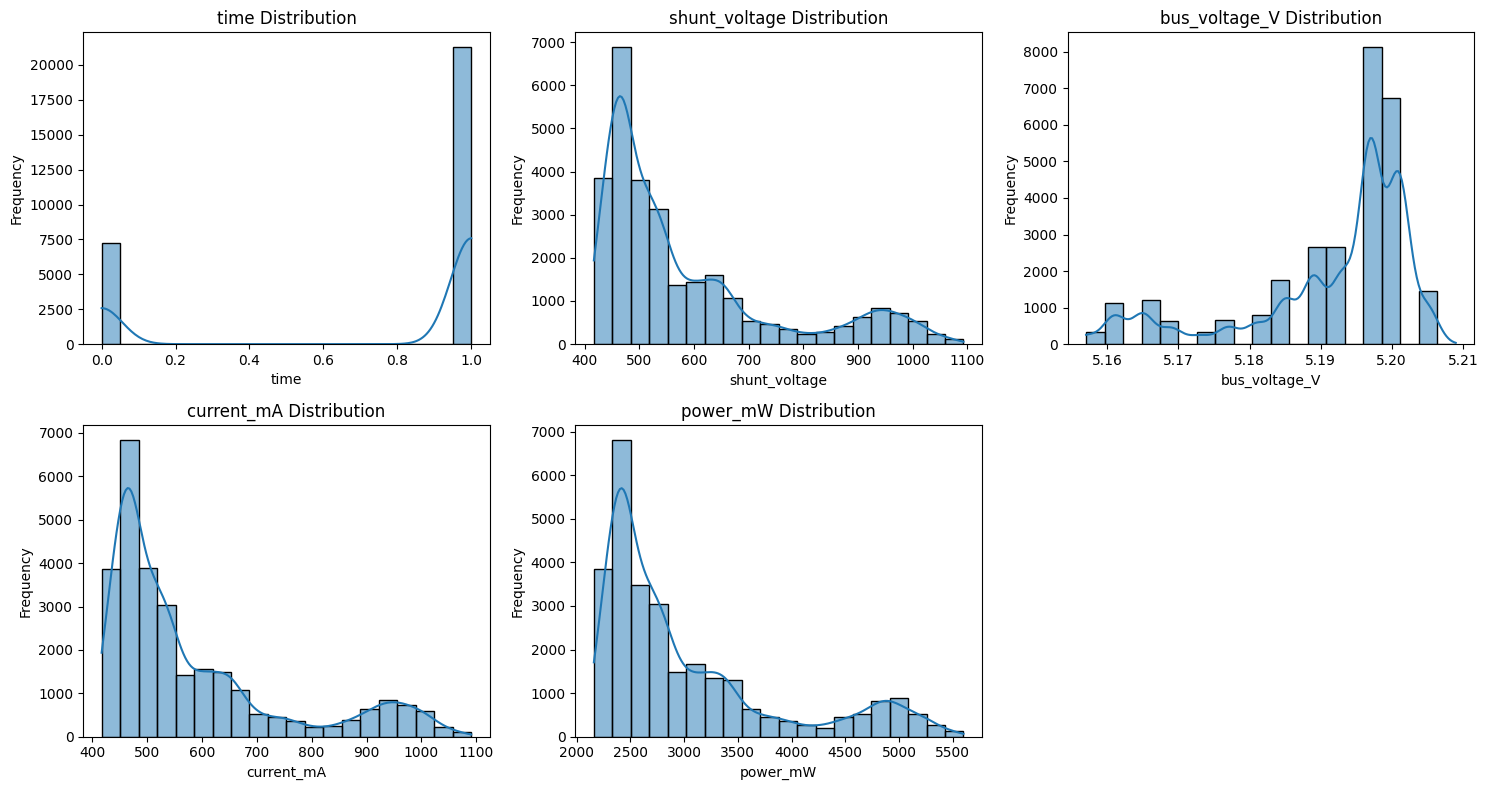

In [45]:
import math

# Feature distribution histograms
plt.figure(figsize=(14, 8))
num_features = len(X_clean.columns)
cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(X_clean.columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(X_clean[col], bins=20, kde=True)
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

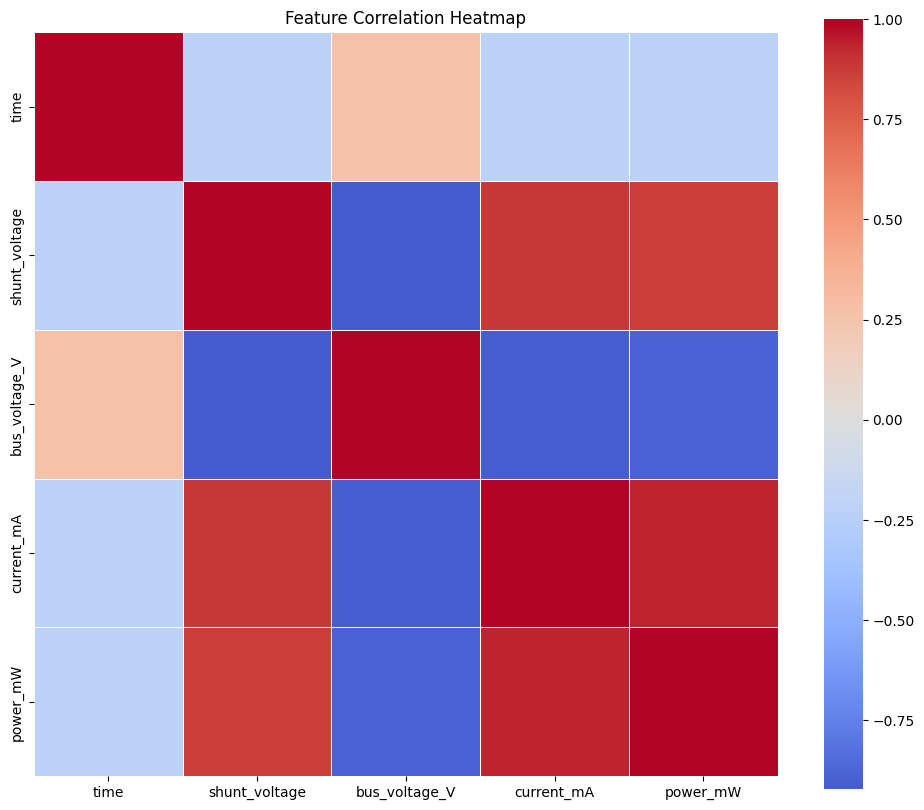

In [46]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = X_clean.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()